In [4]:
''' Test model '''

' Test model '

In [5]:
fp="/Volumes/LaCie/platelet_data/train-error-weights.tif"

In [6]:
# read tif file
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

error_weights = tiff.imread(fp)

KeyboardInterrupt: 

In [ ]:
error_weights.shape

(50, 800, 800)

In [ ]:
error_weights

array([[[0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879],
        [0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879],
        [0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879],
        ...,
        [0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879],
        [0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879],
        [0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879]],

       [[0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879],
        [0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879],
        [0.00180678, 0.00180678, 0.00180678, ..., 0.00117879,
         0.00117879, 0.00117879],
        ...,
        [0.00117879, 0.00117879, 0.07296645, ..., 0.00117879,
         0.00117879, 0.00117879],
        [0.0

In [ ]:
pl

In [ ]:
import models
import importlib
importlib.reload(models)
from models import *
from utilities import *
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
fp="/Users/huayinluo/Documents/code/gapjncsegmentation/models/model_512_5_epoch_100.pth"
model, optimizer, epoch, loss, batch_size, lr, focal_loss_weights = load_checkpoint(model, optimizer, fp)
model = model.eval()

In [1]:
from dataset import SliceDataset
import numpy as np
import os

data_dir = "data/small_data_256"
x_train_dir = os.path.join(data_dir, "original/train")
y_train_dir = os.path.join(data_dir, "ground_truth/train")
x_test_dir = os.path.join(data_dir, "original/test")
y_test_dir = os.path.join(data_dir, "ground_truth/test")

depth, height, width = np.load(os.path.join(x_train_dir, os.listdir(x_train_dir)[0])).shape
train_dataset = SliceDataset(x_train_dir, y_train_dir, image_dim = (width, height), augment=False)
valid_dataset = SliceDataset(x_test_dir, y_test_dir, image_dim = (width, height))

/Users/huayinluo/Documents/code/gapjncsegmentation/gapvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from loss import *
inverse_class_freq = get_inverse_class_frequencies(train_dataset)

In [3]:
print(inverse_class_freq)

[tensor(135.0808), tensor(0.5019)]


In [ ]:
for i in range(len(train_dataset)):
    inputs, labels = train_dataset[i]
    depth, height,
    print(inputs.shape, labels.shape)
    print(torch.sum(labels[0])) # 0: is gap junction, 1: is background (ie. whether or not is positive class)
    print(torch.sum(labels[1])) # 0: is background, 1: is gap junction (ie. whether or not is negative class)
    break

torch.Size([5, 256, 256]) torch.Size([2, 5, 256, 256])
tensor(327156.)
tensor(524.)


In [ ]:
total_pixels_per_img = depth * height * width
print(total_pixels_per_img)

327680


In [ ]:
total_num_gj = 0
for i in range(len(train_dataset)):
    inputs, labels = train_dataset[i]
    num_gj = torch.sum(labels[1])
    total_num_gj += num_gj
    print(f"Processed {i+1}/{len(train_dataset)} images", end="\r")

In [ ]:
total_pixels = len(train_dataset) * total_pixels_per_img
total_num_not_gj = total_pixels - total_num_gj
print(total_num_gj, total_num_not_gj, total_pixels)

tensor(703484.) tensor(1.8935e+08) 190054400


In [ ]:
num_classes = 2
frequencies = [(num_classes*total_num_gj)/total_pixels, (num_classes * total_num_not_gj)/total_pixels]
alpha = [1/f for f in frequencies]
print(frequencies)
print(alpha)

[tensor(0.0074), tensor(1.9926)]
[tensor(135.0808), tensor(0.5019)]


In [ ]:
# scale alpha to be between 0 and 1
alpha_norm = [a/max(alpha) for a in alpha]
alpha_norm

[tensor(1.), tensor(0.0037)]

In [ ]:
[1/total_num_gj, 1/total_num_not_gj]

[tensor(1.4215e-06), tensor(5.2812e-09)]

In [ ]:
from loss import calculate_alpha
weights = calculate_alpha(train_dataset)

/Users/huayinluo/Documents/code/gapjncsegmentation/gapvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
weights

tensor([0.8000, 0.0889])

torch.Size([1, 1, 5, 512, 512]) torch.Size([1, 2, 5, 512, 512])


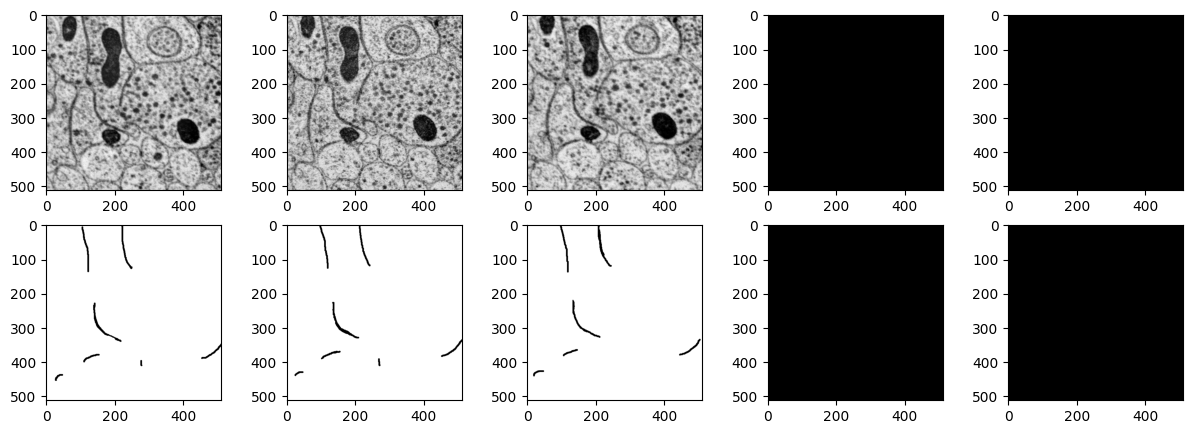

In [ ]:
from visualize import visualize_3d_slice
import matplotlib.pyplot as plt
k = 5
inputs, labels = valid_dataset[k] # 0 is gap junction, 1 is non-gap junction
inputs = inputs.unsqueeze(0).unsqueeze(0)
labels = labels.unsqueeze(0)
print(inputs.shape, labels.shape)
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
visualize_3d_slice(inputs[0, 0], ax[0])
visualize_3d_slice(labels[0, 0], ax[1])
plt.show()


In [ ]:
# takes ~ 30s to run
pred = model(inputs)
print(pred.shape)

: 

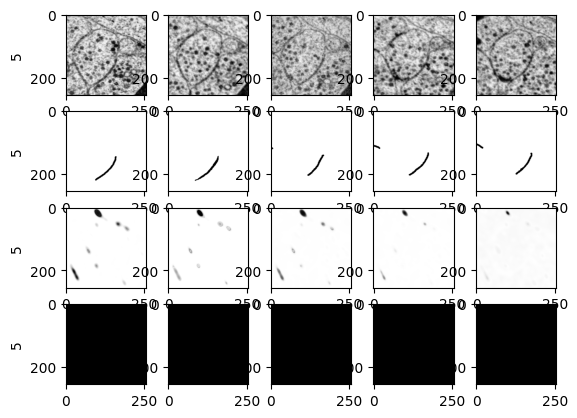

In [ ]:
from visualize import *
input_img = inputs[0, 0].numpy()
label_img = labels[0, 0].numpy()
pred_img = pred[0, 1].detach().numpy()
pred_binary = torch.argmax(pred, dim=1).numpy()[0]
depth, height, width = input_img.shape
fig, ax = plt.subplots(4, depth)
visualize_3d_slice(input_img, ax[0], depth)
visualize_3d_slice(label_img, ax[1], depth)
visualize_3d_slice(pred_img, ax[2], depth)
visualize_3d_slice(pred_binary, ax[3], depth)

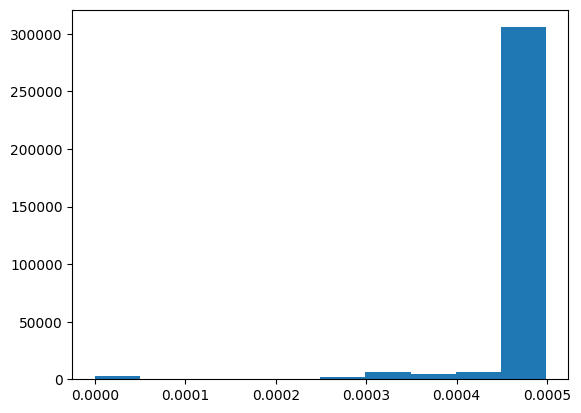

In [ ]:
plt.hist(pred_img.flatten())
plt.show()